In [2]:
from dataset import create_dataset, create_sampler, create_loader
from models.model_bbox import XVLM as XVLM_bbox
from models.model_captioning import XVLM as XVLM_caption

from models import XVLMBase, build_mlp, load_pretrained
config = {'train_file': ['data/finetune/cosmos_train.json'], 'val_file': ['data/finetune/cosmos_val.json'], 
'test_file': ['data/finetune/cosmos_test.json'], 'image_root': 'images/cosmos/', 
'vision_config': 'configs/config_swinB_384.json', 'use_clip_vit': False, 
'use_swin': True, 'image_res': 384, 'patch_size': 32, 'use_roberta': False, 
'text_config': 'configs/config_bert.json', 'text_encoder': 'data/bert-base-uncased', 
'batch_size': 5, 'optimizer': {'opt': 'adamW', 'lr': 3e-05, 'weight_decay': 0.01, 'lr_mult': 2}, 
'schedular': {'sched': 'linear', 'lr': 3e-05, 'epochs': 10, 'num_warmup_steps': 0.1}}

config_caption = {'train_file': ['data/finetune/cosmos_train.json'], 'val_file': ['data/finetune/cosmos_val.json'], 
'test_file': ['data/finetune/cosmos_test.json'], 'image_root': 'images/cosmos/', 
'vision_config': 'configs/config_swinB_384.json', 'use_clip_vit': False, 'use_swin': True, 
'image_res': 384, 'patch_size': 32, 'use_roberta': False, 'text_config': 'configs/config_bert.json', 
'text_encoder': 'data/bert-base-uncased', 'num_dec_layers': 6, 'batch_size_train': 5, 
'batch_size_test': 32, 'max_tokens': 40, 'label_smoothing': 0.1, 'max_length': 20, 'min_length': 5, 
'num_beams': 3, 'prompt': 'a picture of ', 'optimizer': {'opt': 'adamW', 'lr': 1e-05, 
'weight_decay': 0.01, 'lr_mult': 2}, 'schedular': {'sched': 'linear', 'lr': 1e-05, 'epochs': 5, 
'num_warmup_steps': 0.1}, 'start_eval': 0}
# train_dataset, val_dataset, test_dataset = create_dataset('cosmos', config);
# datasets = [train_dataset, val_dataset, test_dataset]


In [3]:
train_loader, val_loader, test_loader = create_loader(datasets, [None, None, None], batch_size=[config['batch_size']] * 3,
                                                          num_workers=[4, 4, 4], is_trains=[True, False, False],
                                                          collate_fns=[None, None, None])

NameError: name 'datasets' is not defined

In [3]:
import torch
import pandas as pd
torch.cuda.set_device(2) 

In [5]:
model_bbox = XVLM_bbox(config=config)
model_bbox.load_pretrained('/root/thesis/X-VLM/checkpoint/checkpoint_best_refcoco.pth', config, is_eval=False)
# odel_bbox = model_bbox.to('cpu');

### load_bbox_pretrain,  False
### Loading pretrained vision encoder
### Loading pretrained text encoder
load checkpoint from /root/thesis/X-VLM/checkpoint/checkpoint_best_refcoco.pth
missing_keys:  []
unexpected_keys:  []


In [8]:
model_caption = XVLM_caption(config=config_caption)
model_caption.load_pretrained('coco_capt_cider_step_44275.th', config, is_eval=False)
model_caption = model_caption.to('cuda');

### Loading pretrained vision encoder
### Loading pretrained text encoder
load_capt_pretrain,  False
### Loading pretrained text encoder
load checkpoint from coco_capt_cider_step_44275.th
missing_keys:  []
unexpected_keys:  []


In [5]:
from models.tokenization_bert import BertTokenizer
from tqdm import tqdm
tokenizer = BertTokenizer.from_pretrained(config['text_encoder'])

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [8]:
device='cpu'
nouns_1 = []
nouns_2 = []
for image, caption1, caption2, targets in tqdm(test_dataset):
    doc = nlp(caption1)
    doc2 = nlp(caption2)
    chunks_1 = [chunk for chunk in doc.noun_chunks]
    chunks_2 = [chunk for chunk in doc2.noun_chunks]
    nouns_1.append(chunks_1)
    nouns_2.append(chunks_2)

100%|██████████| 1700/1700 [00:47<00:00, 35.70it/s]


In [121]:
image = test_dataset[361][0][None,:]
image = image.to('cpu')
torch.manual_seed(42)
model_caption.generate(image,num_return_sequences=5,sample=True, num_beams=1,repetition_penalty=1.2)

(['a group of people sitting on the floor with a statue',
  'a group of people sitting around a monument',
  'a group of people sitting on the steps at a statue',
  'a group of people sitting on the plaza with a statue',
  'a group of people sitting on the floor in front of this statue',
  'a group of people sitting on the plaza with a clock tower',
  'a group of people sitting on the steps in front of a monument',
  'a group of people sitting on the plaza with a statue',
  'a group of people sitting on the ground in front of a sculpture',
  'a group of people sitting in front of a statue'],
 tensor([-0.5618, -0.4725, -0.4850, -0.1975, -0.6351, -0.4676, -0.4646, -0.2193,
         -0.4059, -0.0509], grad_fn=<DivBackward0>))

In [28]:
import numpy as np

In [31]:
torch.manual_seed(42)
device='cuda'
captions = []
for image, _, _, _ in tqdm(test_loader):
    # image = image[None,:]
    image = image.to(device)
    c = model_caption.generate(image,num_return_sequences=3,sample=True, num_beams=1,repetition_penalty=1.5)
    # print(c[0])
    cs = np.array_split(c[0],len(image))
    cs = [list(cs) for cs in cs]

    captions += cs

  0%|          | 0/340 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 340/340 [03:13<00:00,  1.75it/s]


In [33]:
caption_test = open('caption_test.txt').readlines()

In [60]:
df = pd.read_json('/root/thesis/ViLT/cosmos/test_data.json',orient="records", lines=True)

In [64]:
df['nouns_1'] = nouns_1
df['nouns_2'] = nouns_2
df['caption_3'] = captions

In [66]:
df.to_csv('new_data.csv', index=False)

In [26]:
df = pd.read_csv('new_data.csv')

In [31]:
df['nouns_1'] = df['nouns_1'].apply( lambda x: x.strip("[]").replace("'","").split(", "))
df['nouns_2'] = df['nouns_2'].apply( lambda x: x.strip("[]").replace("'","").split(", "))

In [24]:
device='cuda:0'
model_bbox.to(device);

In [28]:
list(df)

['img_local_path',
 'caption1',
 'caption2',
 'context_label',
 'article_url',
 'maskrcnn_bboxes',
 'caption1_modified',
 'caption1_entities',
 'caption2_modified',
 'caption2_entities',
 'bert_base_score',
 'bert_large_score',
 'nouns_1',
 'nouns_2',
 'caption_3',
 'bbs',
 'bbs2',
 'iou']

In [34]:
bbs = []
bbs2 = []
for idx, row in tqdm(df.iterrows(),total=1700):
    image = test_dataset[idx][0][None,:]
    image = image.to(device)
    bbs_=[]
    bbs_2=[]
    text_inputs= tokenizer(row['caption1_modified'], padding='longest', return_tensors="pt",max_length=512, truncation=True).to(device)
    loss = model_bbox(image, text_inputs.input_ids, text_inputs.attention_mask, target_bbox=None)
    bbs.append(loss.cpu().tolist()[0])

    text_inputs= tokenizer(row['caption2_modified'], padding='longest', return_tensors="pt",max_length=512, truncation=True).to(device)
    loss = model_bbox(image, text_inputs.input_ids, text_inputs.attention_mask, target_bbox=None)
    bbs2.append(loss.cpu().tolist()[0])

100%|██████████| 1700/1700 [05:46<00:00,  4.90it/s]


In [23]:
i=6
print('Cap 1:' ,test_dataset[i][1])
print('Cap 2:' ,test_dataset[i][2])
print(df.loc[i].nouns_1)
print(df.loc[i].nouns_2)
print(df.loc[i].bert_base_score)
print(df.loc[i].caption_3)
print('Label:' ,test_dataset[i][3])
try:
    display_image(f'images/cosmos/test/{i}.jpg',bbs[i][0],bbs2[i][0])
except FileNotFoundError:
    display_image(f'images/cosmos/test/{i}.png',bbs[i][0],bbs2[i][0])

Cap 1: A bird (variously described as a goose or a duck) helping to keep a puppy warm
Cap 2: It isn’t unprecedented for birds and dogs to strike up friendships, thus claim is false
['A bird', 'a goose', 'a duck']
['It', 'birds', 'dogs', 'friendships', 'claim']
0.40480524
['two birds sitting on the back of a person', 'an image of two birds standing next to a barrel', 'a group of ducks sitting in the water']
Label: 1


IndexError: list index out of range

In [37]:
df['bbs']=bbs
df['bbs2']=bbs2

In [44]:
def bb_intersection_over_union(boxA, boxB):
	# if len(boxB)==0 or len(boxA)==0:
	# 	return 1

	# boxA = boxA[0]
	# boxB = boxB[0]
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [45]:
df['iou'] = df.apply(lambda x:bb_intersection_over_union(x.bbs,x.bbs2),axis=1)

In [49]:
df[df['iou']<0.5]['context_label'].value_counts()

0    178
1    103
Name: context_label, dtype: int64

In [175]:
df.to_csv('new_data.csv', index=False)

In [24]:
device='cuda'
model_bbox.to(device)
bounding_box1 = []
bounding_box2 = []
for image, caption1, caption2, targets in tqdm(test_loader):
    # caption1[0] = s
    image, targets = image.to(device), targets.to(device)   
    text_inputs_1 = tokenizer(caption1, padding='longest', return_tensors="pt",max_length=512, truncation=True).to(device)
    text_inputs_2 = tokenizer(caption2, padding='longest', return_tensors="pt",max_length=512, truncation=True).to(device)

    loss1 = model_bbox(image, text_inputs_1.input_ids, text_inputs_1.attention_mask, target_bbox=None)
    loss2 = model_bbox(image, text_inputs_2.input_ids, text_inputs_2.attention_mask, target_bbox=None)
    
    bounding_box1.extend(loss1.cpu().tolist())
    bounding_box2.extend(loss2.cpu().tolist())

  0%|          | 0/340 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 340/340 [00:36<00:00,  9.29it/s]


In [12]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
def display_image(path,bbox_1, bbox_2):
    img = Image.open(path).convert('RGB')
    w,h=img.size
    plt.imshow(img)

    # Get the current reference
    ax = plt.gca()

    # Create a Rectangle patch
    rect = Rectangle((bbox_1[0] *w - (bbox_1[2]*w)/2, bbox_1[1]*h-(bbox_1[3]*h)/2),
     bbox_1[2]*w, bbox_1[3]*h,linewidth=1,edgecolor='r',facecolor='none')
    rect2 = Rectangle((bbox_2[0] *w - (bbox_2[2]*w)/2, bbox_2[1]*h-(bbox_2[3]*h)/2),
     bbox_2[2]*w, bbox_2[3]*h,linewidth=1,edgecolor='y',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    ax.add_patch(rect2)
    

In [19]:
test_dataset[0][1]

'PERSON at his announcement in GPE, GPE, on DATE. Mr. PERSON, the former secretary of housing and urban development, would be one of the youngest presidents if elected.'

Cap 1: A sculpture of PERSON and a GPE man in the GPE region of GPE. The area is under a heavy security presence
Cap 2: A statue of PERSON and a GPE in GPE, GPE. The area is heavily guarded.
Label: 0


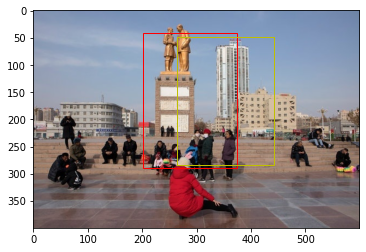

In [36]:
i = 361
print('Cap 1:' ,test_dataset[i][1])
print('Cap 2:' ,test_dataset[i][2])
print('Label:' ,test_dataset[i][3])
display_image(f'images/cosmos/test/{i}.jpg',bounding_box1[i], bounding_box2[i])

In [54]:
test_dataset[0][0][None,:].shape

torch.Size([1, 3, 384, 384])

In [52]:
torch.tensor(test_dataset[0][0]).shape

/tmp/ipykernel_1203047/2324433235.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(test_dataset[0][0]).shape


torch.Size([3, 384, 384])

In [76]:
z.shape

torch.Size([3, 384, 384])

In [10]:
device='cuda'
model_bbox.to(device)
def predict(image, text):
    # image = test_dataset[0][0][None,:]
    image = image[None,:]
    image = image.to(device)

    text = tokenizer(text, padding='longest', return_tensors="pt",max_length=512, truncation=True).to(device)
    loss = model_bbox(image, text.input_ids, text.attention_mask, target_bbox=None)
    return loss.cpu().tolist()

Cap 1: Actor PERSON and his son, rapper PERSON, had “died in a crash after a “car and truck collision”
Cap 2: This post was a hoax, as neither Will nor PERSON had died or been seriously injured in an automobile accident.
Label: 1


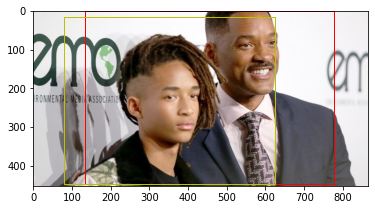

In [25]:
i=33
b = predict(test_dataset[i][0],[test_dataset[i][1]])
b2 = predict(test_dataset[i][0],[test_dataset[i][2]])
# b = predict(test_dataset[i][0],['general view'])
# b2 = predict(test_dataset[i][0],['high-rise buildings'])
print('Cap 1:' ,test_dataset[i][1])
print('Cap 2:' ,test_dataset[i][2])
print('Label:' ,test_dataset[i][3])
try:
    display_image(f'images/cosmos/test/{i}.jpg',b[0], b2[0])
except FileNotFoundError:
    display_image(f'images/cosmos/test/{i}.png',b[0], b2[0])

In [41]:
import pandas as pd
df = pd.DataFrame(columns=['caption1','caption2','target'])
for image, caption1, caption2, targets in tqdm(test_loader):
    # df = df.append([caption1, caption2, targets])
    for c1,c2,t in zip(caption1, caption2, targets):
        df.loc[len(df)] = [c1,c2,t.item()]

  0%|          | 0/340 [00:00<?, ?it/s][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
100%|██████████| 340/340 [00:08<00:00, 38.81it/s]


In [43]:
df['predict'] = prediction

In [44]:
confusion_matrix = pd.crosstab(df['target'], df['predict'], rownames=['target'], colnames=['predict'])
print (confusion_matrix)

predict    0    1
target           
0        746  104
1        587  263


In [7]:
torch.cat([torch.tensor([5,2]), torch.tensor([5,2])],dim=-1)

tensor([5, 2, 5, 2])

In [9]:
loss

tensor([[ 0.0831, -0.3668],
        [ 0.0402, -0.0914],
        [-0.0596, -0.3729],
        [-0.2012, -0.3863],
        [-0.0547, -0.1801]], device='cuda:1', grad_fn=<AddmmBackward>)

In [5]:
device='cuda'
for (image0, image1, text, targets) in train_loader:
    images = torch.cat([image0, image1], dim=0)
    images, targets = images.to(device), targets.to(device)   
    
    text_inputs = tokenizer(text, padding='longest', return_tensors="pt").to(device)  
    
    loss = model(images, text_inputs.input_ids, text_inputs.attention_mask, targets=targets, train=True)
    break

NameError: name 'torch' is not defined

In [7]:
from models.xbert import BertConfig, BertForMaskedLM, BertModel
config_text = BertConfig.from_json_file(config['text_config'])
text_encoder = BertModel(config=config_text, add_pooling_layer=False)

In [8]:
image_embeds, image_atts = model.get_vision_embeds(images)

In [9]:
image_embeds.shape, image_atts.shape

(torch.Size([10, 145, 1024]), torch.Size([10, 145]))

In [10]:
image_embeds, image_atts = model.get_vision_embeds(images)
image0_embeds, image1_embeds = torch.split(image_embeds, targets.size(0))
(text_ids, text_atts) = text_inputs.input_ids, text_inputs.attention_mask
r = model.get_cross_embeds([image0_embeds, image1_embeds], 
    [image_atts[:image0_embeds.size(0)], image_atts[image0_embeds.size(0):]],
    text_ids=text_ids, text_atts=text_atts)

In [14]:
r[:, 0, :].shape

torch.Size([5, 768])

In [1]:
text_encoder, init = build_text_encoder(config, vision_width=145,  config_text=config_text)
#text_encoder = BertModel(config=config_text, add_pooling_layer=False)

NameError: name 'BertModel' is not defined

In [38]:
text_ids.shape, text_atts.shape, image_embeds.shape, image_atts.shape

(torch.Size([5, 19]),
 torch.Size([5, 19]),
 torch.Size([10, 145, 1024]),
 torch.Size([10, 145]))

In [49]:
b = text_encoder(text_ids,
            attention_mask=text_atts,
            encoder_hidden_states=[image0_embeds, image1_embeds],
            encoder_attention_mask=[image_atts[:image0_embeds.size(0)], image_atts[image0_embeds.size(0):]],
            return_dict=True,)

AttributeError: 'list' object has no attribute 'dim'

In [48]:
b.last_hidden_state.shape

torch.Size([5, 19, 768])